In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 11
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((516, 12, 1), (516,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT11/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 19s 219ms/step - loss: 0.2710 - root_mean_squared_error: 0.5206 - val_loss: 0.1962 - val_root_mean_squared_error: 0.4430
Epoch 2/50
53/53 [==============================] - 10s 186ms/step - loss: 0.1841 - root_mean_squared_error: 0.4291 - val_loss: 0.1081 - val_root_mean_squared_error: 0.3287
Epoch 3/50
53/53 [==============================] - 10s 187ms/step - loss: 0.1225 - root_mean_squared_error: 0.3500 - val_loss: 0.0999 - val_root_mean_squared_error: 0.3160
Epoch 4/50
53/53 [==============================] - 10s 193ms/step - loss: 0.1087 - root_mean_squared_error: 0.3297 - val_loss: 0.0914 - val_root_mean_squared_error: 0.3023
Epoch 5/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0979 - root_mean_squared_error: 0.3129 - val_loss: 0.0842 - val_root_mean_squared_error: 0.2902
Epoch 6/50
53/53 [==============================] - 10s 186ms/step - loss: 0.0825 - root_mean_squared_error: 0.2872 - val_loss: 0.0665 

53/53 [==============================] - 2s 31ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805
Epoch 38/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886
Epoch 39/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 40/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0728
Epoch 41/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 42/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0109 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.1732701818148294 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

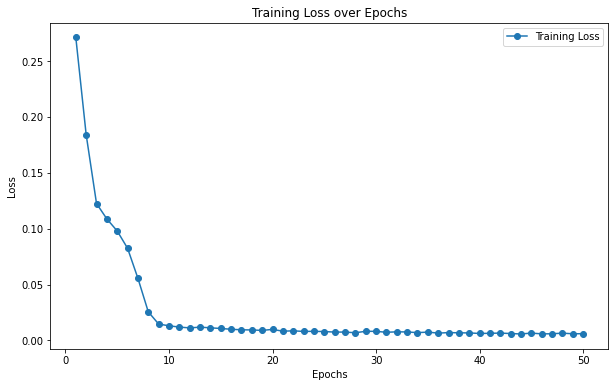

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

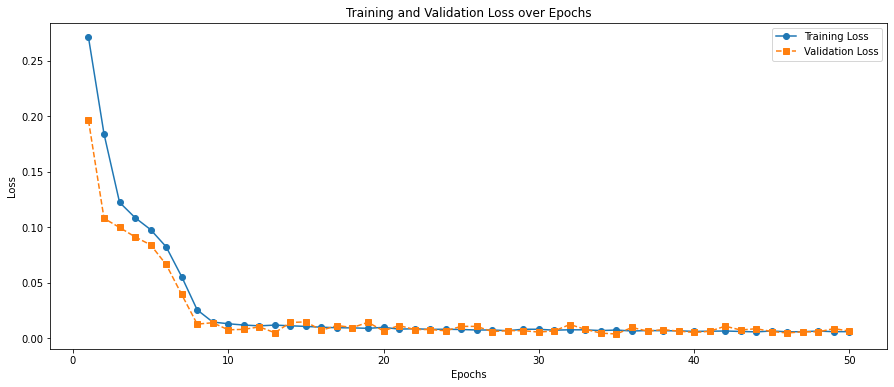

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT11/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 19ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.05922361644209797
MAE : 0.04814686181246287


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.375240e+05,444914.605
1,5.480391e+05,827036.916
2,1.052670e+06,1142021.216
3,1.712953e+06,1885693.654
4,2.467251e+06,2542569.663
5,3.162705e+06,3107373.845
6,3.577880e+06,3488175.444
7,3.589698e+06,3746306.528
8,3.216958e+06,2942322.822
9,2.157466e+06,1507212.955


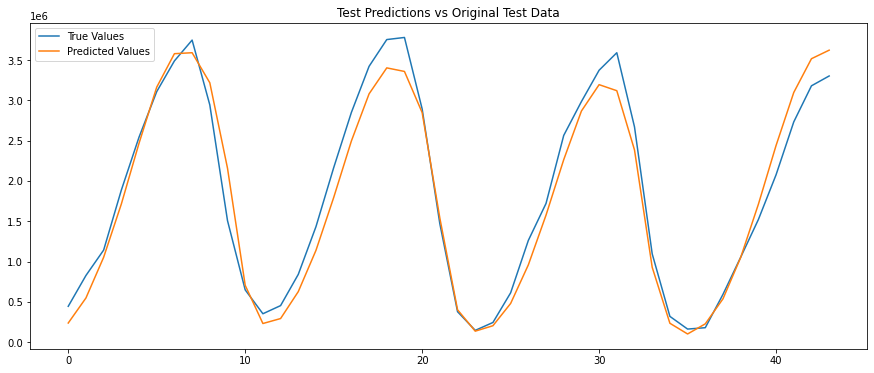

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

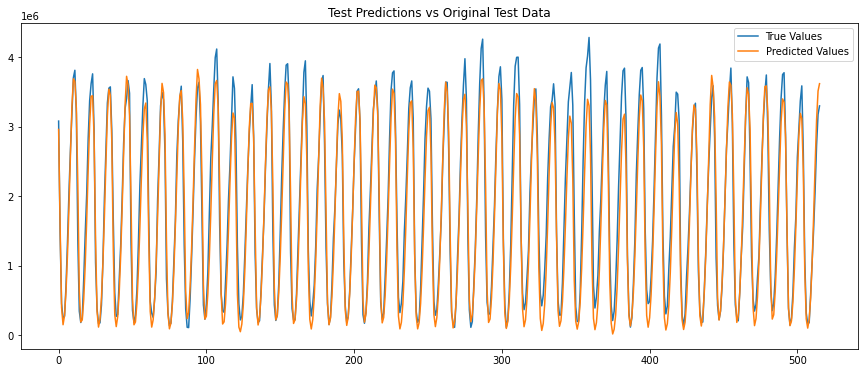

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()